In [98]:
from cfl.experiment import Experiment
import numpy as np
import pandas as pd
from cfl.visualization.basic_visualizations import visualize_macrostates
from sklearn.preprocessing import StandardScaler
from cfl_helpers import *

In [99]:
resolution = '40km'
file = f'data/{resolution}_data.csv'

data = pd.read_csv(file)
Xraw = np.array(data[['lat', 'long']])
Yraw = np.array(data['generated_temp']).reshape(-1,1)
print(Xraw.shape, Yraw.shape)

(833, 2) (833, 1)


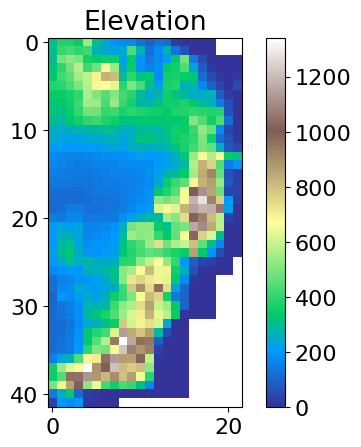

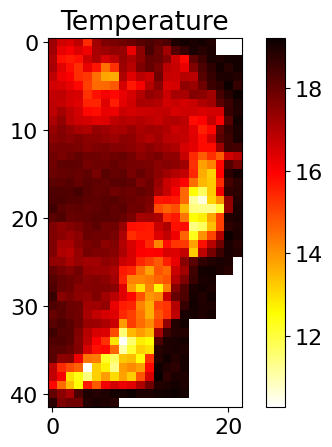

In [100]:
# PLOT TEMP AND ELEVATION FOR RAW DATAFRAME

alt_grid, temp_grid = get_alt_temp_grids(data)

plt.figure(1)
plt.imshow(alt_grid, cmap='terrain', interpolation='nearest')
plt.colorbar()
plt.title('Elevation')
plt.show()

plt.figure(2)
plt.imshow(temp_grid, cmap='hot_r', interpolation='nearest')
plt.colorbar()
plt.title('Temperature')
plt.show()

In [101]:
X = StandardScaler().fit_transform(Xraw)
Y = StandardScaler().fit_transform(Yraw)

In [102]:
# Create 3 dictionaries: one for data info, one with CDE parameters, and one with cluster parameters

# the parameters should be passed in dictionary form
data_info = {'X_dims' : X.shape,
             'Y_dims' : Y.shape,
             'Y_type' : 'continuous' #options: 'categorical' or 'continuous'
            }

# pass in empty parameter dictionaries to use the default parameter values (not
# allowed for data_info)
CDE_params = {  'model'        : 'CondExpMod',
                'model_params' : {
                    # model architecture
                    'dense_units' : [50, data_info['Y_dims'][1]],
                    'activations' : ['relu', 'linear'],
                    'dropouts'    : [0, 0],
                    # training parameters
                    'batch_size'  : 16,
                    'n_epochs'    : 2500,
                    'optimizer'   : 'adam',
                    'opt_config'  : {'lr' : 1e-4},
                    'loss'        : 'mean_squared_error',
                    'best'        : True,
                    'early_stopping' : True,
                    # verbosity
                    'verbose'     : 1,
                    'show_plot'   : True,
                }
}

# cluster_params consists of specifying two clustering objects
# CFL automatically recognizes the names of all sklearn.cluster models as keywords
cause_cluster_params =  {'model' : 'KMeans',
                         'model_params' : {'n_clusters' : 100},
                         'verbose' : 0
}

In [103]:
# block_names indicates which CDE and clustering models to use
block_names = ['CondDensityEstimator', 'CauseClusterer']

# block_params is aligned to block_names
block_params = [CDE_params, cause_cluster_params]

results_path = 'sample_run' # directory to save results to

# Create a new CFL experiment with specified parameters
my_exp = Experiment(X_train=X,
                    Y_train=Y,
                    data_info=data_info,
                    block_names=block_names,
                    block_params=block_params,
                    results_path=results_path)

All results from this run will be saved to sample_run/experiment0018
Block: verbose not specified in input, defaulting to 1
CondExpBase: activity_regularizers not specified in input, defaulting to None
CondExpBase: kernel_regularizers not specified in input, defaulting to None
CondExpBase: bias_regularizers not specified in input, defaulting to None
CondExpBase: kernel_initializers not specified in input, defaulting to None
CondExpBase: bias_initializers not specified in input, defaulting to None
CondExpBase: weights_path not specified in input, defaulting to None
CondExpBase: tb_path not specified in input, defaulting to None
CondExpBase: optuna_callback not specified in input, defaulting to None
CondExpBase: optuna_trial not specified in input, defaulting to None
CondExpBase: checkpoint_name not specified in input, defaulting to tmp_checkpoints


#################### Beginning CFL Experiment training. ####################
Beginning CondDensityEstimator training...
No GPU device detected.
Epoch 1/2500
39/39 [==============================] - 1s 5ms/step - loss: 1.3766 - val_loss: 1.2139
Epoch 2/2500
39/39 [==============================] - 0s 2ms/step - loss: 1.3341 - val_loss: 1.1788
Epoch 3/2500
39/39 [==============================] - 0s 3ms/step - loss: 1.2962 - val_loss: 1.1471
Epoch 4/2500
39/39 [==============================] - 0s 3ms/step - loss: 1.2634 - val_loss: 1.1207
Epoch 5/2500
39/39 [==============================] - 0s 3ms/step - loss: 1.2343 - val_loss: 1.0975
Epoch 6/2500
39/39 [==============================] - 0s 2ms/step - loss: 1.2084 - val_loss: 1.0768
Epoch 7/2500
39/39 [==============================] - 0s 2ms/step - loss: 1.1862 - val_loss: 1.0584
Epoch 8/2500
39/39 [==============================] - 0s 2ms/step - loss: 1.1656 - val_loss: 1.0437
Epoch 9/2500
39/39 [==============================] - 0s

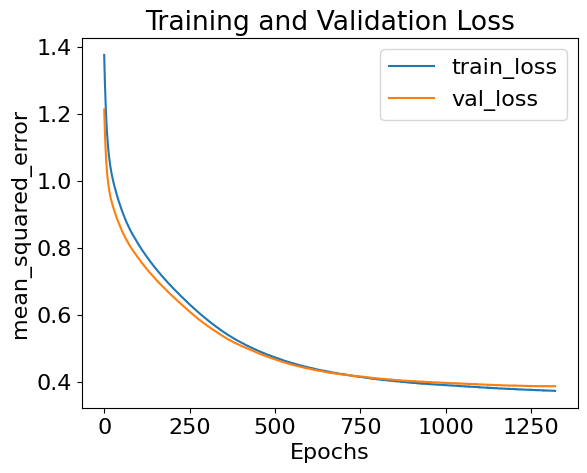

27/27 [==============================] - 0s 5ms/step
Loading parameters from  tmp_checkpoints31012025110655/best_weights
Saving parameters to  sample_run/experiment0018/trained_blocks/CondDensityEstimator
CondDensityEstimator training complete.
Beginning CauseClusterer training...
CauseClusterer training complete.
Experiment training complete.


In [104]:
results = my_exp.train()

# Reconstruct the elevation map based on labels

# LOOK IN DATA, POINTS ARE GROUPED BY LAT

# does ylbls even matter?

In [105]:
xlbls = results['CauseClusterer']['x_lbls']
# ylbls = results['EffectClusterer']['y_lbls']

print(xlbls[:10], xlbls[-5:])
# print(ylbls[:10], ylbls[-5:])
print(len(xlbls))

[69 48 61 43 47 29  5 86 54 51] [99 73 68 19 65]
833


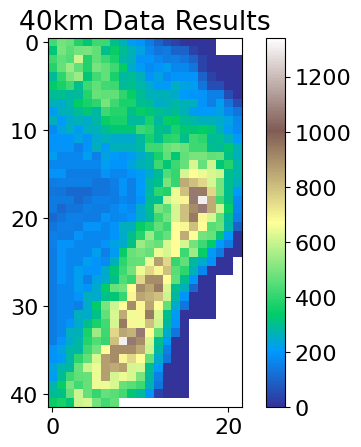

In [106]:
reconstruct_alts = reconstruct_groups(data, xlbls, title=f'{resolution} Data Results')

# for 25km, used 50 clusters, for 10km, used 100 clusters

# WANT TO CLASSIFY ACCURACY

mean absolute error: 96.7001306689828


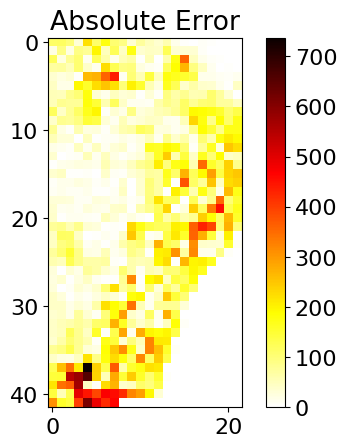

mean squared error: 20401.987773028122


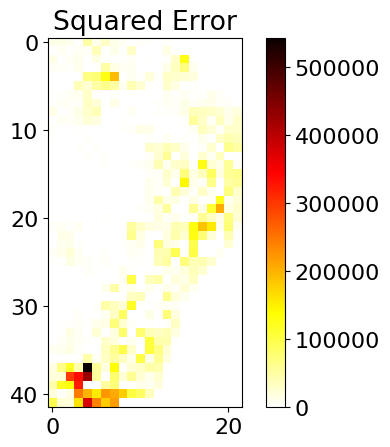

In [107]:
print(f'mean absolute error: {err(alt_grid, reconstruct_alts, "mean_abs")}')
plot_err(alt_grid, reconstruct_alts, 'abs')

print(f'mean squared error: {err(alt_grid, reconstruct_alts, "mean_squared")}')
plot_err(alt_grid, reconstruct_alts, 'squared')

# Why does clustering always miss the southernmost peaks?